In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import SCRBenchmark.SRSDFeynman as srsdf
from SCRBenchmark import Benchmark
import SCRBenchmark.Constants.StringKeys as sk


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=UserWarning)

def reportConstraintViolation(valid,constraints):
    if(valid):
        print("No Constraint Violated\n")
    else:
        print(f"Violated the constraints: ")
        for constraint in constraints:
          print(f"  id {constraint[sk.EQUATION_CONSTRAINTS_ID_KEY]} - over {constraint[sk.EQUATION_CONSTRAINTS_VAR_DISPLAY_NAME_KEY]} order {constraint[sk.EQUATION_CONSTRAINTS_ORDER_DERIVATIVE_KEY]}: {constraint[sk.EQUATION_CONSTRAINTS_DESCRIPTOR_KEY]}")

# Checking Constraints

## Analyzing the original equation
Equation I.6.20, with 

$f(\sigma, \theta) = \frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\theta}{\sigma}\right)^{\!2}\,\right)$

is the probabilistic density function of the normal distribution. 
We can analyze the contour plot of this function to determine possible constraints.

Text(0, 0.5, 'sigma')

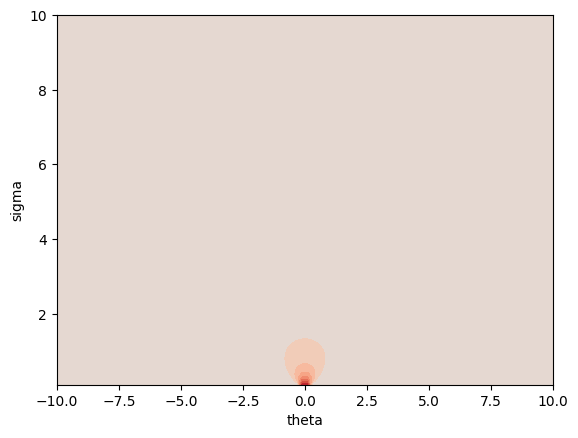

In [2]:
ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)

xlist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

grid_z_pos = ICh6Eq20.equation.calculate((X,Y))

norm = Normalize( vmin=-np.max(grid_z_pos), vmax=np.max(grid_z_pos))
cmap = plt.colormaps['coolwarm']

ax = plt.subplot()
plt.contourf(X, Y, grid_z_pos, cmap= cmap , norm= norm)
ax.set_xlabel('theta')
ax.set_ylabel('sigma')


If we _zoom in_ to theta [-1,1] and sigma [0.1,1.5] we can see the effect more clearly:

(0.1, 1.5)

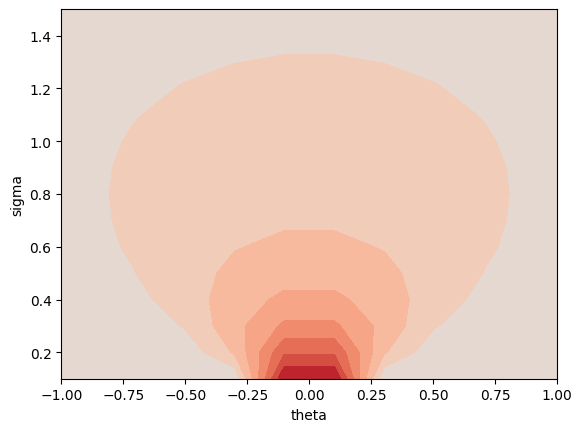

In [3]:
ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)

xlist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

grid_z_pos = ICh6Eq20.equation.calculate((X,Y))

norm = Normalize( vmin=-np.max(grid_z_pos), vmax=np.max(grid_z_pos))
cmap = plt.colormaps['coolwarm']

ax = plt.subplot()
plt.contourf(X, Y, grid_z_pos, cmap= cmap , norm= norm)
ax.set_xlabel('theta')
ax.set_ylabel('sigma')
ax.set_xlim([-1,1])
ax.set_ylim([0.1,1.5])


We can see that, if we hold sigma constant for any of its values, theta is
monotonic increasing in theta < -0.1 and monotonic decreasing in theta > 0.1. This can
also be determined algorithmically for any given equation. 

## Determine constraints algorithmically
The constraints can be determined algorithmically by:

1. Calculating the partial derivatives of the function for each input using SymPy. 
1. Sampling a uniform dataset for the defined input space. 
    1. For ICh6Eq20 e.g., sampling for sigma is defined as `
       DefaultSampling(1.0e-1, 1.0e1, uses_negative=False)` so [0.1,10] with a
       skew towards 0.1. Whereas, theta is defined as `DefaultSampling(1.0e-1,
       1.0e1)` resulting in a union of [-10,-0.1] and [0.1,10] with a higher
       density at the joint (see `./examples/generate_data.ipynb` for more
       details).
    1. Therefore, we split theta into positive and negative values and investigate the two quadrants `sigma,theta in [0.1,10]x[0.1,10]` and `sigma,theta in [0.1,10]x[-10,-0.1]` separately.
    1. This step is repeated until all inputs, where positive and negative values are sampled, are split into two areas.
1. We iterate over all sample subspaces and over all partial derivatives and calculate the gradient.
1. If all values are e.g. positive, then the function is monotonically decreasing over the variable used for the partial derivative in the sampled subspace.

This results in the following constraints for ICh6Eq20:
```json
 "Constraints": [
      {
        "var_name": "",
        "var_display_name": "",
        "order_derivative": 0,
        "descriptor": "positive",
        "derivative": "sqrt(2)*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1)",
        "sample_space": [
          {
            "name": "x0",
            "low": -10.0,
            "high": -0.1
          },
          {
            "name": "x1",
            "low": 0.1,
            "high": 10.0
          }
        ],
        "id": 0
      },
      {
        "var_name": "",
        "var_display_name": "",
        "order_derivative": 0,
        "descriptor": "positive",
        "derivative": "sqrt(2)*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1)",
        "sample_space": [
          {
            "name": "x0",
            "low": 0.1,
            "high": 10.0
          },
          {
            "name": "x1",
            "low": 0.1,
            "high": 10.0
          }
        ],
        "id": 1
      },
      {
        "var_name": "x0",
        "var_display_name": "theta",
        "order_derivative": 1,
        "descriptor": "positive",
        "derivative": "-sqrt(2)*x0*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**3)",
        "sample_space": [
          {
            "name": "x0",
            "low": -10.0,
            "high": 0.0
          },
          {
            "name": "x1",
            "low": 0.1,
            "high": 10.0
          }
        ],
        "id": 2
      },
      {
        "var_name": "x0",
        "var_display_name": "theta",
        "order_derivative": 1,
        "descriptor": "negative",
        "derivative": "-sqrt(2)*x0*exp(-x0**2/(2*x1**2))/(2*sqrt(pi)*x1**3)",
        "sample_space": [
          {
            "name": "x0",
            "low": 0.0,
            "high": 10.0
          },
          {
            "name": "x1",
            "low": 0.1,
            "high": 10.0
          }
        ],
        "id": 3
      }
    ]
```

**cf. `./generate/1-sample_constraints.py` for details.**

## Check constraints for a given function

Checking constraints for a provided function is implemented similarly to the determination of constraints for the original equation function. However, as we know all available constraints and their respective input space for which they apply, we create only those subspaces for which we have constraints available.

The following example illustrates functionality of our `benchmark.check_constraints`

### potential solutions: $-(theta*theta)$ and $(theta*theta)$
The following contour plot should visualize that this $-(theta*theta) + 400$ (is
a very bad fit for data sampled from ICh6Eq20) but does fit the known
constraints. Whereas, $(theta*theta) - 400$ violates all available constraints

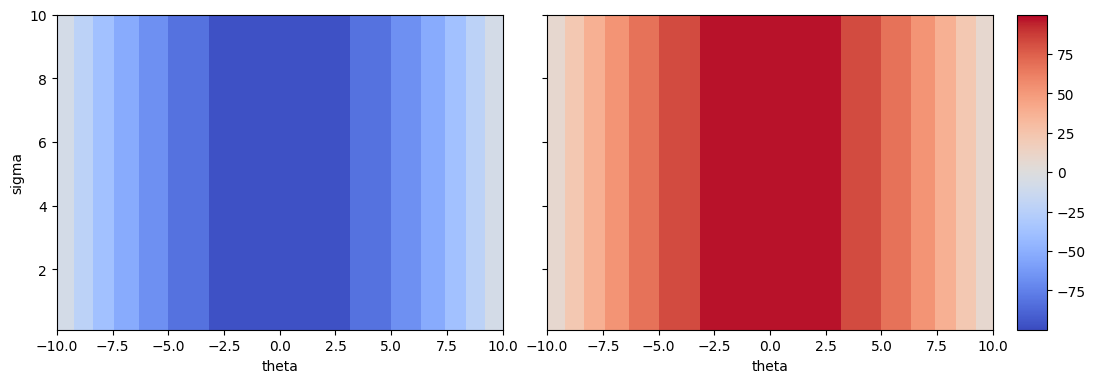

In [22]:
ist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

def f1(theta,sigma):
    return (theta*theta) - 100
def f2(theta,sigma):
    return -(theta*theta) + 100

grid_z_pos1 = f1(X,Y)
grid_z_pos2 = f2(X,Y)

fig, ax = plt.subplots(1,2, figsize=(12,5),  sharey=True)
norm = Normalize( vmin=np.min([np.min(grid_z_pos1), np.min(grid_z_pos2)]), 
                  vmax=np.max([np.max(grid_z_pos1), np.max(grid_z_pos2)]))
cmap = plt.colormaps['coolwarm']

ax[0].contourf(X, Y, grid_z_pos1, cmap= cmap , norm= norm)
ax[1].contourf(X, Y, grid_z_pos2, cmap= cmap , norm= norm)
ax[0].set_xlabel('theta')
ax[1].set_xlabel('theta')
ax[0].set_ylabel('sigma')

plt.subplots_adjust(left=0.09, bottom=0.22, right=0.87, top=0.85, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([.89, .22, .025, .63])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax = cbar_ax)

In [23]:
(valid, constraints) = ICh6Eq20.check_constraints("(theta*theta) - 100",use_display_names=True)
reportConstraintViolation(valid, constraints)

Violated the constraints: 
  id 0 - over  order 0: positive
  id 1 - over  order 0: positive
  id 2 - over theta order 1: positive
  id 3 - over theta order 1: negative


In [24]:
(valid, constraints) = ICh6Eq20.check_constraints("-(theta*theta) + 100",use_display_names=True)
reportConstraintViolation(valid, constraints)

No Constraint Violated



### potential solutions: $theta$ and $-theta$
Are both constructed to violate only one constraint. Therefore, our interface returns false and lists only the one violated constraint in its full definition.

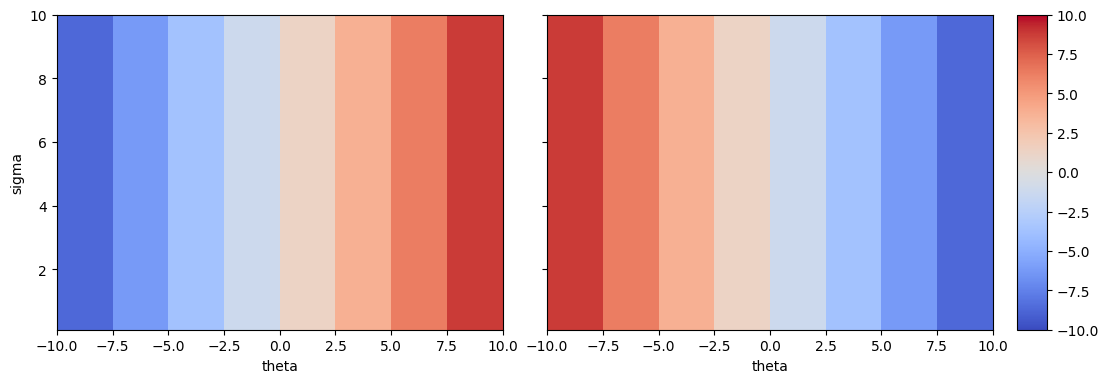

In [25]:
ist = np.linspace(-10,10, 100) # the valid range of theta for ICh6Eq20 (except for [-0.1,0.1])
ylist = np.linspace(0.1, 10, 100) # the valid range of sigma for ICh6Eq20
X, Y = np.meshgrid(xlist, ylist)

def f1(theta,sigma):
    return theta
def f2(theta,sigma):
    return -theta
grid_z_pos1 = f1(X,Y)
grid_z_pos2 = f2(X,Y)

fig, ax = plt.subplots(1,2, figsize=(12,5),  sharey=True)
norm = Normalize( vmin=np.min([np.min(grid_z_pos1), np.min(grid_z_pos2)]), 
                  vmax=np.max([np.max(grid_z_pos1), np.max(grid_z_pos2)]))
cmap = plt.colormaps['coolwarm']

ax[0].contourf(X, Y, grid_z_pos1, cmap= cmap , norm= norm)
ax[1].contourf(X, Y, grid_z_pos2, cmap= cmap , norm= norm)
ax[0].set_xlabel('theta')
ax[1].set_xlabel('theta')
ax[0].set_ylabel('sigma')

plt.subplots_adjust(left=0.09, bottom=0.22, right=0.87, top=0.85, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([.89, .22, .025, .63])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax = cbar_ax)

In [26]:
(valid, constraints) = ICh6Eq20.check_constraints("theta",use_display_names=True)
reportConstraintViolation(valid, constraints)

Violated the constraints: 
  id 0 - over  order 0: positive
  id 3 - over theta order 1: negative


In [27]:
(valid, constraints) = ICh6Eq20.check_constraints("-theta",use_display_names=True)
reportConstraintViolation(valid, constraints)

Violated the constraints: 
  id 1 - over  order 0: positive
  id 2 - over theta order 1: positive


## Alternative usages and variable names
The examples above utilize the human-readable display names of the equations. Instead, we can also use the numbered inputs and interchange functionality freely.

In [28]:
ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20)
# Raw: exp(-(theta / sigma) ** 2 / 2) / (sqrt(2 * pi) * sigma)
# is monotonic increasing over theta in -inf. <= theta <= 0
# is monotonic decreasing over theta in 0 <= theta <= inf.

############################################
#use the short variable names of SRSDFeynman
############################################

#prints true as no constraint is violated in the tested input domain
reportConstraintViolation(*ICh6Eq20.check_constraints("-(x0*x0)+100"))

#prints false as the image of the function is not positive
reportConstraintViolation(*ICh6Eq20.check_constraints("-(x0*x0)"))

#prints false as both constraints for x0 (theta) are violated
reportConstraintViolation(*ICh6Eq20.check_constraints("(x0*x0)"))

ICh6Eq20 = Benchmark(srsdf.FeynmanICh6Eq20, initialize_constraint_checking_datasets = False)
########################################################################
# test the same function, expect the same outputs, but use display names
########################################################################
#prints true as no constraint is violated in the tested input domain
reportConstraintViolation(*ICh6Eq20.check_constraints("-(theta*theta)+100",use_display_names=True))

#prints false as the image of the function is not positive
reportConstraintViolation(*ICh6Eq20.check_constraints("-(theta*theta)",use_display_names=True))

#prints false as both constraints for x0 (theta) are violated
reportConstraintViolation(*ICh6Eq20.check_constraints("(theta*theta)",use_display_names=True))

No Constraint Violated

Violated the constraints: 
  id 0 - over  order 0: positive
  id 1 - over  order 0: positive
Violated the constraints: 
  id 2 - over theta order 1: positive
  id 3 - over theta order 1: negative
No Constraint Violated

Violated the constraints: 
  id 0 - over  order 0: positive
  id 1 - over  order 0: positive
Violated the constraints: 
  id 2 - over theta order 1: positive
  id 3 - over theta order 1: negative
